In [1]:
!pip install -q pytorch-lightning
!pip install torchmetrics
!pip install torchvision
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 40.1 MB/s eta 0:00:00


In [2]:
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL

In [50]:
class Config:
    image_target_size = (64,64)
    batch_size = 64
    num_of_workers = 2
    learning_rate = 1e-3
    weight_decay = 1e-4
    num_of_epochs = 50
    latent_dims = 256

In [102]:
from torch.utils.data import DataLoader

class Flowers102DataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.CenterCrop(500),
            transforms.Resize(Config.image_target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1),
        ])
        self.test_transform = transforms.Compose([
            transforms.CenterCrop(500),
            transforms.Resize(Config.image_target_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1),
        ])

        self.reverse_transform = transforms.Compose([
            transforms.Lambda(lambda t: (t + 1) / 2),
            transforms.Lambda(lambda t: t.permute(1, 2, 0)),
            transforms.Lambda(lambda t: t * 255.),
            transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ])

        self.image_folder = '/content/ddpm/data'

    def setup(self, stage=None):
        self.train_dataset = torchvision.datasets.Flowers102(root=self.image_folder, split='test', download=True, transform=self.train_transform)
        self.val_dataset = torchvision.datasets.Flowers102(root=self.image_folder, split='val', download=True, transform=self.test_transform)
        self.test_dataset = torchvision.datasets.Flowers102(root=self.image_folder, split='train', download=True, transform=self.test_transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=Config.batch_size,
            num_workers=Config.num_of_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=Config.batch_size,
            num_workers=Config.num_of_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=Config.batch_size,
            num_workers=Config.num_of_workers,
            pin_memory=True,
        )

In [70]:
datamodule = Flowers102DataModule()
datamodule.prepare_data()
datamodule.setup()

In [108]:
from torchvision import transforms
import torch

def up_scale_images(
        images: torch.Tensor,
        inverse_transform: transforms,
        target_size = (299, 299),
        interpolation: transforms.InterpolationMode = transforms.InterpolationMode.BICUBIC
    ):
    up_scale_transform = transforms.Compose([
        transforms.Resize(target_size, interpolation, antialias=True),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 255.0)
    ])

    num_images = len(images)
    image_shape = (3, 299, 299)

    upscaled_images = torch.empty((num_images, *image_shape), dtype=torch.uint8).to(torch.device('cuda'))

    for i, image in enumerate(images):
        upscaled_images[i] = up_scale_transform(inverse_transform(image))

    return upscaled_images.to(torch.uint8)

In [109]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

class BaseLineImageGenerationVAE(pl.LightningModule):
    def __init__(self, latent_dim, in_channels=3, inverse_transform=None):
        super().__init__()
        self.save_hyperparameters()
        self.inverse_transform = inverse_transform
        hidden_dims=[32, 64, 128, 256, 512]
        self.final_dim = hidden_dims[-1]
        modules = []

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        out = self.encoder(torch.rand(1, 3, Config.image_target_size[0], Config.image_target_size[1]))
        self.size = out.shape[2]
        self.fc_mu = nn.Linear(hidden_dims[-1] * self.size * self.size, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * self.size * self.size, latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * self.size * self.size)
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3,
                      kernel_size=3, padding=1),
            nn.Sigmoid())

        # Setup Inception and Frechet Inception Distance scoring for test
        self.inception = InceptionScore()
        self.fid = FrechetInceptionDistance(feature=64)

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, self.final_dim, self.size, self.size)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    @staticmethod
    def loss_function(recon_x, x, mu, log_var):
        MSE = F.mse_loss(recon_x, x.view(-1, 3 * Config.image_target_size[0] * Config.image_target_size[1]))
        KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        kld_weight = 0.00025
        loss = MSE + kld_weight * KLD
        return loss

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        z = self.decode(z)
        z = torch.flatten(z, start_dim=1)
        z = torch.nan_to_num(z)
        return z, mu, log_var

    def training_step(self, batch, batch_idx):
        image, _ = batch
        recon_batch, mu, log_var = self(image)
        log_var = torch.clamp_(log_var, -10, 10)
        loss = BaseLineImageGenerationVAE.loss_function(recon_batch, image, mu, log_var)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, _ = batch
        recon_batch, mu, log_var = self(image)
        log_var = torch.clamp_(log_var, -10, 10)
        loss = BaseLineImageGenerationVAE.loss_function(recon_batch, image, mu, log_var)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        image, _ = batch
        recon_batch, mu, log_var = self(image)
        log_var = torch.clamp_(log_var, -10, 10)
        loss = BaseLineImageGenerationVAE.loss_function(recon_batch, image, mu, log_var)
        upscaled_orig = up_scale_images(image, self.inverse_transform)
        upscaled_gen = up_scale_images(recon_batch.reshape((-1, 3) + Config.image_target_size), self.inverse_transform)

        self.inception.update(upscaled_gen)
        self.fid.update(upscaled_orig, real=True)
        self.fid.update(upscaled_gen, real=False)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        inception_score = self.inception.compute()
        fid_score = self.fid.compute()
        self.log("test_inception_mean", inception_score[0])
        self.log("test_inception_std", inception_score[1])
        self.log("test_fid", fid_score)
        return super().on_test_epoch_end()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)


In [122]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min", dirpath=f'/content/ddpm/model/vae-baseline', filename='best', save_top_k=1)
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=10, verbose=False, mode="min")
logger = pl.loggers.tensorboard.TensorBoardLogger(save_dir='/content/ddpm/logs', name='vae-baseline')

In [123]:
trainer = pl.Trainer(
        max_epochs=100,
        logger=logger,
        devices=1,
        accelerator='gpu',
        callbacks=[checkpoint_callback, early_stopping_callback],
        log_every_n_steps=1,
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [124]:
model = BaseLineImageGenerationVAE(Config.latent_dims)

trainer.fit(model, datamodule)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/ddpm/model/vae-baseline exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | encoder       | Sequential               | 1.6 M  | train
1 | fc_mu         | Linear                   | 524 K  | train
2 | fc_var        | Linear                   | 524 K  | train
3 | decoder_input | Linear                   | 526 K  | train
4 | decoder       | Sequential               | 1.6 M  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [125]:
model_path = trainer.checkpoint_callback.best_model_path
model = BaseLineImageGenerationVAE.load_from_checkpoint(model_path, map_location='cuda', strict=True)

In [126]:
model.inverse_transform = datamodule.reverse_transform

In [127]:
test_result = trainer.test(model, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_fid          │     8.432150840759277     │
│    test_inception_mean    │     3.121363878250122     │
│    test_inception_std     │    0.13987624645233154    │
│         test_loss         │    0.2698024809360504     │
└───────────────────────────┴───────────────────────────┘

In [116]:
import json
with open('/content/vae-stat.json', 'w') as output:
        json.dump({
            'inception_mean': test_result[0]['test_inception_mean'],
            'inception_std': test_result[0]['test_inception_std'],
            'fid': test_result[0]['test_fid'],
            'loss': test_result[0]['test_loss']
        }, output, indent=4)

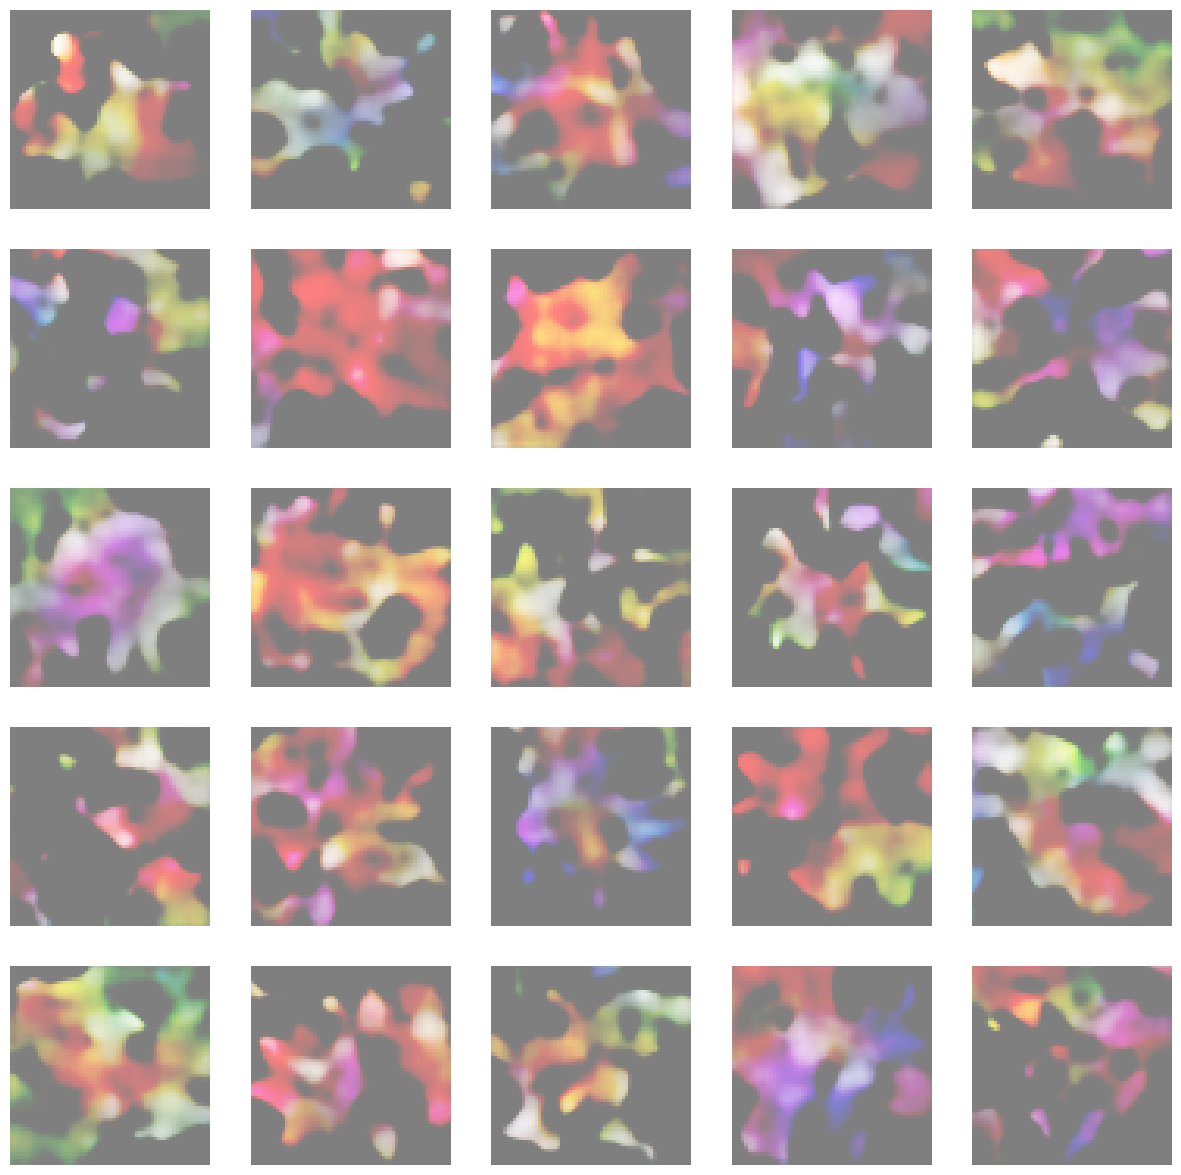

In [128]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

with torch.no_grad():
  random_vector = torch.randn(25, Config.latent_dims).to(model.device)
  generated_images = model.decode(random_vector)
  generated_images = generated_images.reshape((-1, 3) + Config.image_target_size)
  for image, ax in zip(generated_images, axes.flatten()):
    generated_image = datamodule.reverse_transform(image)
    ax.imshow(generated_image)
    ax.axis('off')
plt.show()